In this tutorial we will use OTT to implement a loss based on soft ranks to train a neural network for image classification, as it was done by [Cuturi et al. 2019](https://arxiv.org/abs/1905.11885).

This implementation relies on [flax](https://github.com/google/flax) a neural network library for jax.

## Imports

First of all, we need to import some packages.

In [1]:
import collections
import functools
from typing import Any

import flax
from flax import jax_utils
from flax.training import common_utils
from flax import linen as nn

import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import ml_collections
import tensorflow as tf
import tensorflow_datasets as tfds

from colabtools import adhoc_import
with adhoc_import.Google3():
  import ott

## Model

Similarly to [Cuturi et al. 2019](https://arxiv.org/abs/1905.11885), we will train a vanilla CNN made of 4 convolutional blocks.

In [2]:
class ConvBlock(nn.Module):
  """A simple CNN blockl."""

  features: int = 32
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, x, train: bool = True):
    x = nn.Conv(features=self.features, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.Conv(features=self.features, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    return x


class CNN(nn.Module):
  """A simple CNN model."""

  num_classes: int = 10
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, x, train: bool = True):
    x = ConvBlock(features=32)(x)
    x = ConvBlock(features=64)(x)
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=512)(x)
    x = nn.relu(x)
    x = nn.Dense(features=self.num_classes)(x)
    x = nn.log_softmax(x)
    return x

## Data

We use tensorflow datasets to load and augment cifar10.

In [3]:
def prepare_tf_data(xs):
  """Convert a input batch from tf Tensors to numpy arrays."""
  local_device_count = jax.local_device_count()
  def _prepare(x):
    # Use _numpy() for zero-copy conversion between TF and NumPy.
    x = x._numpy()
    return x.reshape((local_device_count, -1) + x.shape[1:])

  return jax.tree_map(_prepare, xs)

def create_input_iter(dataset_builder, batch_size, train):
  split = tfds.Split.TRAIN if train else tfds.Split.TEST
  ds = dataset_builder.as_dataset(split=split)
  if train:
    ds = ds.repeat()
    ds = ds.shuffle(16 * batch_size, seed=0)

  def prepare_for_train(inputs):
    im = inputs['image']
    im = tf.image.random_flip_left_right(im)
    im = tf.image.random_crop(im, (28, 28, 3))
    im = tf.image.pad_to_bounding_box(im, 2, 2, 32, 32)
    im = tf.cast(im, dtype=tf.float32)
    im = tf.image.per_image_standardization(im)
    inputs['image'] = im
    inputs.pop('id')
    return inputs

  def prepare_for_eval(inputs):
    im = inputs['image']
    # im = tf.image.pad_to_bounding_box(im[2:,2:], 1, 1, 32, 32)
    im = tf.cast(im, dtype=tf.float32)
    im = tf.image.per_image_standardization(im)
    inputs['image'] = im
    inputs.pop('id')
    return inputs

  prepare_fn = prepare_for_train if train else prepare_for_eval
  ds = ds.map(prepare_fn, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.batch(batch_size, drop_remainder=True)

  if not train:
    ds = ds.repeat()

  ds = ds.prefetch(10)
  it = map(prepare_tf_data, ds)
  it = jax_utils.prefetch_to_device(it, 2)
  return it

## Losses

Here we consider as a loss the soft error based on soft ranks. The idea is to consider the loss to be zero if the logit of the true class ranks on top, that is to say in our case has rank 9 (since we have 10 classes).

In [23]:
def cross_entropy_loss(logits, labels):
  num_labels = logits.shape[1]
  one_hots = common_utils.onehot(labels, num_classes=num_labels)
  return -jnp.sum(one_hots * logits) / labels.size


def soft_error_loss(logits, labels, correct=True):
  num_labels = logits.shape[1]
  one_hots = common_utils.onehot(labels, num_classes=num_labels)
  soft_ranks = ott.tools.soft_sort.ranks(logits, axis=1)
  return jnp.mean(nn.relu(
      num_labels - 1 - jnp.sum(one_hots * soft_ranks, axis=1)))
  
LOSSES = {
    'cross_entropy': cross_entropy_loss,
    'soft_error': soft_error_loss
    }

## Training Loop

We define a training loop based on Flax. For more information, please refer to the [Flax examples](https://github.com/google/flax/tree/master/examples).

In [25]:
def initialized(key, height, width, model):
  input_shape = (1, height, width, 3)

  @jax.jit
  def init(*args):
    return model.init(*args)

  variables = init({'params': key},
                   jnp.ones(input_shape, jnp.float32))
  model_state, params = variables.pop('params')
  return params, model_state


def compute_metrics(logits, labels, loss_fn):
  loss = loss_fn(logits, labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  metrics = jax.lax.pmean(metrics, axis_name='batch')
  return metrics


def train_step(apply_fn, loss_fn, state, batch):
  """Perform a single training step."""

  def compute_loss(params):
    variables = {'params': params, **state.model_state}
    logits = apply_fn(variables, batch['image'])
    loss = loss_fn(logits, batch['label'])
    return loss, logits

  grad_fn = jax.value_and_grad(compute_loss, has_aux=True)
  aux, grad = grad_fn(state.optimizer.target)
  # Re-use same axis_name as in the call to `pmap(...train_step...)` below.
  grad = jax.lax.pmean(grad, axis_name='batch')
  logits = aux[1]
  new_optimizer = state.optimizer.apply_gradient(grad)
  metrics = compute_metrics(logits, batch['label'], loss_fn=loss_fn)
  new_state = state.replace(step=state.step + 1, optimizer=new_optimizer)
  return new_state, metrics


def eval_step(apply_fn, loss_fn, state, batch):
  params = state.optimizer.target
  variables = {'params': params, **state.model_state}
  logits = apply_fn(variables, batch['image'], train=False, mutable=False)
  return compute_metrics(logits, batch['label'], loss_fn=loss_fn)


@flax.struct.dataclass
class TrainState:
  step: int
  optimizer: flax.optim.Optimizer
  model_state: Any


def create_train_state(rng, config, model, height, width):
  """Create initial training state."""
  platform = jax.local_devices()[0].platform
  params, model_state = initialized(rng, height, width, model)
  optimizer = flax.optim.Momentum(
      learning_rate=config.learning_rate,
      beta=config.momentum, nesterov=True).create(params)
  state = TrainState(step=0, optimizer=optimizer, model_state=model_state)
  return state


def log(results, epoch, summary, train=True, end='\r'):
  phase = 'train' if train else 'eval'
  for key in ('loss', 'accuracy'):
    results[f'{phase}_{key}'].append((epoch + 1, summary[key]))
  print('{} epoch: {}, loss: {:.3f}, accuracy: {:.2%}'.format(
      phase, epoch + 1, summary['loss'], summary['accuracy']), end=end)


def train_and_evaluate(config: ml_collections.ConfigDict, seed: int = 0):
  """Executes model training and evaluation loop."""
  rng = jax.random.PRNGKey(seed)

  if config.batch_size % jax.device_count() > 0:
    raise ValueError('Batch size must be divisible by the number of devices')

  loss_fn = LOSSES.get(config.loss, None)
  if loss_fn is None:
    raise ValueError(
        f'Unknown loss {config.loss}. Possible values: {",".join(LOSSES)}')

  local_batch_size = config.batch_size // jax.host_count()
  platform = jax.local_devices()[0].platform
  dataset_builder = tfds.builder(config.dataset)
  info = dataset_builder.info
  height, width = info.features['image'].shape[:2]
  train_iter = create_input_iter(dataset_builder, local_batch_size, train=True)
  eval_iter = create_input_iter(dataset_builder, local_batch_size, train=False)
  steps_per_epoch = info.splits['train'].num_examples // config.batch_size
  num_steps = int(steps_per_epoch * config.num_epochs)
  num_validation_examples = info.splits['test'].num_examples
  steps_per_eval = num_validation_examples // config.batch_size

  num_classes = info.features['label'].num_classes
  model = CNN(num_classes=num_classes, dtype=jnp.float32)
  state = create_train_state(rng, config, model, height, width)
  state = jax_utils.replicate(state)

  p_train_step = jax.pmap(
      functools.partial(train_step, model.apply, loss_fn), axis_name='batch')
  p_eval_step = jax.pmap(
      functools.partial(eval_step, model.apply, loss_fn), axis_name='batch')
  
  results = collections.defaultdict(list)
  epoch_metrics = []
  for step, batch in zip(range(num_steps), train_iter):
    state, metrics = p_train_step(state=state, batch=batch)
    epoch_metrics.append(metrics)

    if (step + 1) % steps_per_epoch == 0:
      epoch = step // steps_per_epoch
      epoch_metrics = common_utils.get_metrics(epoch_metrics)
      summary = jax.tree_map(lambda x: x.mean(), epoch_metrics)
      log(results, epoch, summary, train=True)

      epoch_metrics = []
      eval_metrics = []
      for _ in range(steps_per_eval):
        eval_batch = next(eval_iter)
        metrics = p_eval_step(state, eval_batch)
        eval_metrics.append(metrics)
      eval_metrics = common_utils.get_metrics(eval_metrics)
      summary = jax.tree_map(lambda x: x.mean(), eval_metrics)
      log(results, epoch, summary, train=False)

  # Wait until computations are done before exiting
  jax.random.normal(jax.random.PRNGKey(0), ()).block_until_ready()
  return results, state

## Run

In [27]:
config = ml_collections.ConfigDict()
config.dataset = 'cifar10'
config.learning_rate = 1e-4
config.momentum = 0.9
config.batch_size = 64
config.num_epochs = 200

In [28]:
results = {}
for loss in LOSSES:
  config.loss = loss
  curves, _ = train_and_evaluate(config)
  results[loss] = {k: np.array(v) for k, v in curves.items()}

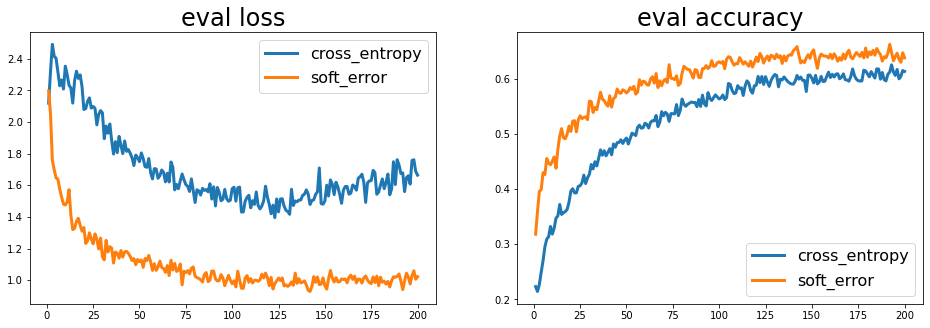

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
phase = 'eval'
for ax, metric in zip(axes, ['loss', 'accuracy']):
  for label, c in results.items():
    ax.plot(*c[f'{phase}_{metric}'].T, label=label, lw=3)
  ax.legend(fontsize=16)
  ax.set_title(f'{phase} {metric}', fontsize=24)